# Lab 10 - Linear Models

In [1]:
%matplotlib inline

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

### General Instructions

1.  You will be submitting your assignment to Blackboard. If there are no accompanying files, you should submit *only* your notebook and it should be named using *only* your JHED id: fsmith79.ipynb for example if your JHED id were "fsmith79". If the assignment requires additional files, you should name the *folder/directory* your JHED id and put all items in that folder/directory, ZIP it up (only ZIP...no other compression), and submit it to Blackboard.
    
    * do **not** use absolute paths in your notebooks. All resources should appear in the same directory as the rest of your assignments.
    * the directory **must** be named your JHED id and **only** your JHED id.
    
2. Data Science is as much about what you write (communicating) as the code you execute (researching). In many places, you will be required to execute code and discuss both the purpose and the result. Additionally, Data Science is about reproducibility and transparency. This includes good communication with your team and possibly with yourself. Therefore, you must show **all** work.

3. Avail yourself of the Markdown/Codecell nature of the notebook. If you don't know about Markdown, look it up. Your notebooks should not look like ransom notes. Don't make everything bold. Clearly indicate what question you are answering.

4. Submit a cleanly executed notebook. It should say `In [1]` for the first codecell and increase by 1 throughout.

## Linear Regression

In a previous module (Lab 5), you performed EDA on the insurance data set. In this Lab, you should build a linear regression model trying to estimate `charges`.

In [2]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

sns.set(style="whitegrid")

# Answer

Before we start anything, let's first take a look at brief look at the data again

In [3]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


There are 6 regressors, and `charges` is what we are trying to estimate. Since 6 is a fairly small number, we can test out all possible combinations of regressors, and evaluate them. Let's go ahead and do that

In [4]:
import itertools

def powerset(iterable, max_length):
    "Return all combinations of sizes 1 to `max_length`"
    for r in range(1, max_length + 1):
        yield from itertools.combinations(iterable, r)
        
def compose(y_name, regressors) -> str:
    return y_name + " ~ " + " + ".join(regressors)

In [5]:
regressors = set(data.columns).difference(['charges'])

In [6]:
import models

In [7]:
my_models = [
    models.linear_regression(compose("charges", xs), data) 
    for xs in powerset(regressors, len(regressors))
]

Now that we have all the possible models (not including any transformations, let's go ahead and add the adjusted R-squared values to each. This is useful because it allows us to penalize that models that use more features than necessary

In [8]:
def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

In [9]:
for m in my_models:
    m["adj_r_squared"] = adjusted_r_squared(m)
    
my_models[:2]

[{'formula': 'charges ~ age',
  'n': 1338,
  'coefficients': array([3165.88500606,  257.72261867]),
  'r_squared': 0.08940589967885804,
  'residuals': array([[ 8822.30923927],
         [-6079.33984207],
         [-5932.65632874],
         ...,
         [-6175.05864207],
         [-6570.11499807],
         [10254.39555526]]),
  'sigma': 11560.308843529909,
  'adj_r_squared': 0.08735808685954505},
 {'formula': 'charges ~ children',
  'n': 1338,
  'coefficients': array([12522.49554964,   683.08938248]),
  'r_squared': 0.004623758854459203,
  'residuals': array([[  4362.42845036],
         [-11480.03263213],
         [-10122.30169709],
         ...,
         [-10892.66204964],
         [-10514.55054964],
         [ 16618.86475036]]),
  'sigma': 12086.502767112392,
  'adj_r_squared': 0.0023852815505336356}]

Finally, let's rank all of the models by their $R^2_{adjusted}$ and see the top model

In [10]:
ranked_models = sorted(my_models, reverse = True, key = lambda x: x["adj_r_squared"] )
models.simple_describe_lr(ranked_models[0])

How did our models do in terms of their $R^2$ and $R^2_{adjusted}$ scores?

In [11]:
adj_r2s = [m["adj_r_squared"] for m in ranked_models]
r2s = [m["r_squared"] for m in ranked_models]

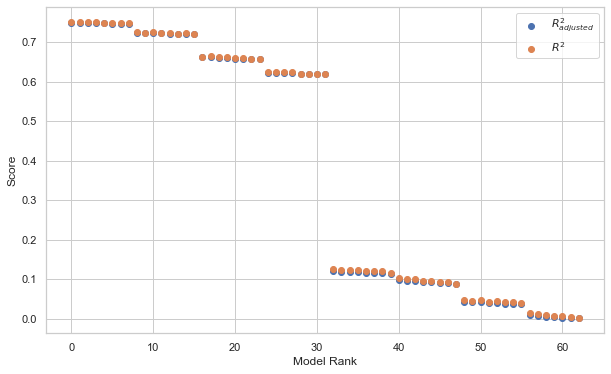

In [12]:
xs = list(range(len(adj_r2s)))

fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(
    x = xs, 
    y = adj_r2s,
    label = "$R^2_{adjusted}$",
)
ax.scatter(
    x = xs,
    y = r2s,
    label = "$R^2$",
)
ax.set_xlabel("Model Rank")
ax.set_ylabel("Score")
ax.legend()

This plot is not entirely useful in our lab, but it is interesting to note how well various models fit the data.

Let's move on to plots of the residual. An ideal plot of the residuals on the y-axis should show only noise. If there is a clear pattern to the residuals, this may indicate a pattern that our regression could take advantage of. We'll use our top ranked model.

Text(0.5, 0, 'Residual Index')

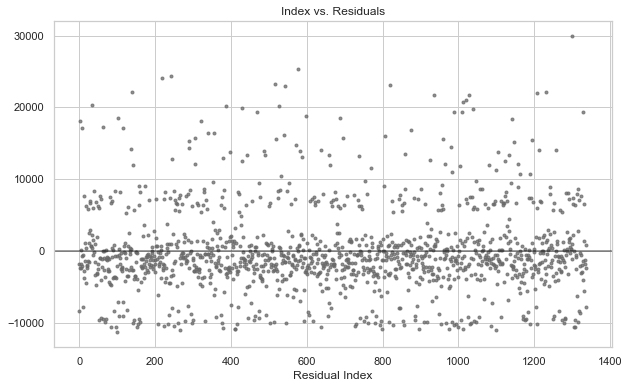

In [13]:
m1 = ranked_models[0]

fig = plt.figure(figsize = (10,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(list(range(0, m1[ "n"])), m1["residuals"], '.', color="dimgray", alpha=0.75)
axes.axhline(y=0.0, xmin=0, xmax=m1["n"], c="black", alpha=0.5)
axes.set_title( "Index vs. Residuals")
axes.set_xlabel( "Residual Index")

Off the bat, we get some very useful information. 

1. Much of the noise seems to be random around 0, with perhaps a slight preference to be mroe negative than positive. Perhaps this could be because there are some very positive outliers which might tip the scales? 
1. There are two definite bands around the central band of mostly Normal noise. Becuase they are approximately equal distances away from the central band, this suggests that they might be related to a categorical issue. To investigate this, we could replot for each categorical variable, with location on the x-axis as sorted by that variable
1. Our model is prone to under-estimating some data points by a great deal

In [14]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

The categorical regressors are `sex`, `smoker`, and `region`. 

In [15]:
def plot_residuals_sorted(data, result, feature):
        
    data["residual"] = result["residuals"]
    sorted_resids = data.sort_values(by = feature).residual
    sorted_feature = data.sort_values(by = feature)[feature]
        
    # Sort the residuals by `feature`      
#     residuals_and_feature = sorted(zip(result["residuals"], data[feature]), key = lambda x: x[-1])
#     sorted_feature = [x[-1] for x in residuals_and_feature]
#     sorted_resids = [x[0] for x in residuals_and_feature]
    
    fig = plt.figure(figsize = (20,6))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(
        list(range(0, result[ "n"])),
        sorted_resids,
        '.',
        color="dimgray",
        alpha=0.75
    )
    
    ax1.axhline(
        y=0.0,
        xmin=0,
        xmax=result["n"],
        c="black",
        alpha=0.5
    )
    
    ax1.set_title( "Index vs. Residuals")
    ax1.set_xlabel( "Residual Index")
    
    try:
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(
            sorted_feature,
            sorted_resids,
            '.',
            color="dimgray",
            alpha=0.75
        )

        ax2.axhline(
            y=0.0,
            xmin=0,
            xmax=result["n"],
            c="black",
            alpha=0.5
        )

        ax2.set_title( "Index vs. Residuals")
        ax2.set_xlabel( "Category")
    except:
        pass

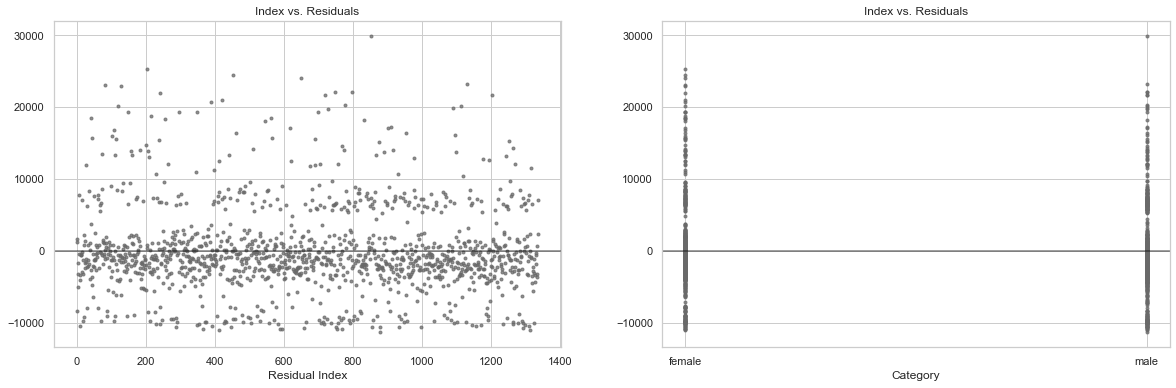

In [16]:
plot_residuals_sorted(data, m1, "sex")

This seems undistinguishable from the original, suggesting that `sex` does not account for the double band.

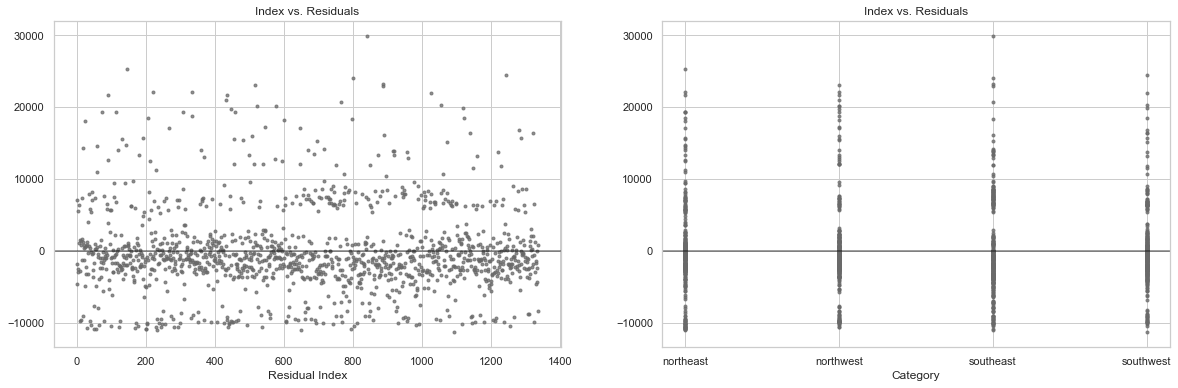

In [17]:
plot_residuals_sorted(data, m1, "region")

Plotting by region does not seem to show any strongly discernable pattern in residuals. 

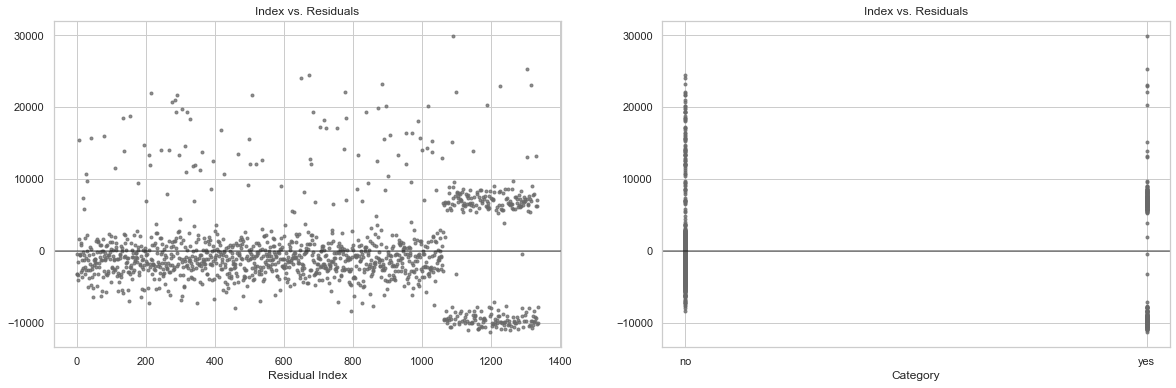

In [18]:
plot_residuals_sorted(data, m1, "smoker")

Aha! Clearly, our model is not very good at estimating the charges for smokers. It almost always either overestimates by around \\$10.000, or underestimates by a bit under \\$10,000. 

I have a hunch that smokers' BMI might be an important thing to take note of. Let's try creating an interaction term between `smoker` and `bmi`

In [19]:
m_2 = models.linear_regression("charges ~ bmi + smoker + age + region + children + smoker:bmi", data)
m_2["adj_r_squared"] = adjusted_r_squared(m_2)
models.simple_describe_lr(m_2)

In [20]:
m_2["adj_r_squared"]

0.8392941488615648

Already, our new model has an $R^2$ and $R^2_{adjusted}$ higher than anything we could create. This is a good sign. Now let's take a look at that regression plot. We'll sort by `smoker` and then by `bmi`

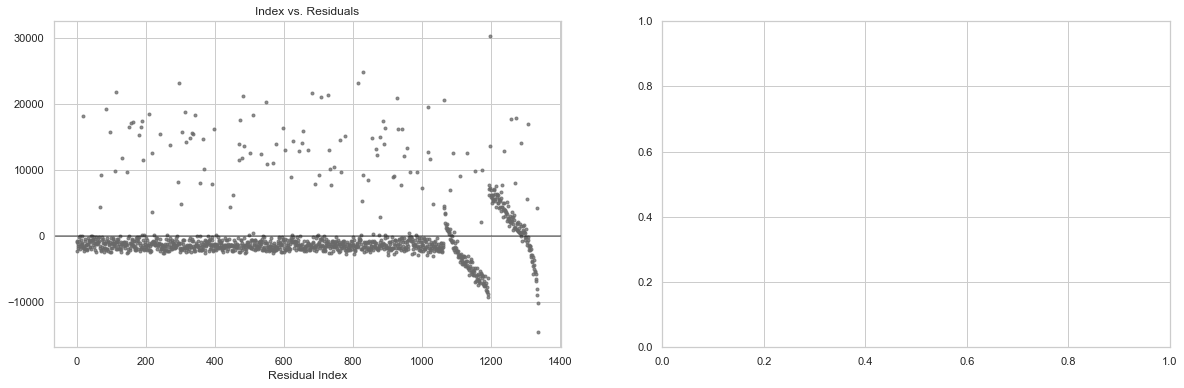

In [21]:
plot_residuals_sorted(data, m_2, ["smoker","bmi"])

Much better! The residuals in the non-smokers have decreased dramatically, and we have extracted a very interesting pattern among the smokers: as `bmi` increases, the residuals decrease, then jump and decrease again! Let's go back to our EDA, and draw a simple scatter plot of `charges` and `bmi`

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


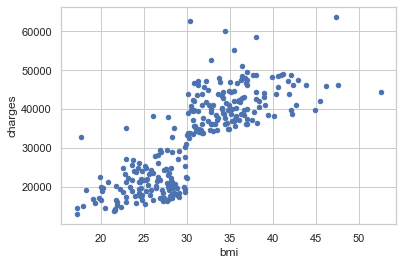

In [22]:
data.loc[data.smoker.eq("yes")].sort_values("bmi").plot.scatter(y = "charges", x = "bmi")

As we cross the threshold of a `bmi` of 30, charges dramatically increase. Let's take a leaf from Lab 5 and create a new feature called `obese` that is false when `bmi` < 30, and true when > 30. Then let's re-fit our data

In [23]:
data["obese"] = data.bmi > 30

m_3 = models.linear_regression("charges ~ bmi + smoker + age + region + children + smoker:bmi + obese", data)
m_3["adj_r_squared"] = adjusted_r_squared(m_3)
models.simple_describe_lr(m_3)

In [24]:
m_3["adj_r_squared"]

0.8452817597627195

This provides a very slightly better adjusted $R^2$ value, but not by much. Let's plot the residuals again and sort by `smoker`, `bmi`, and `obese`

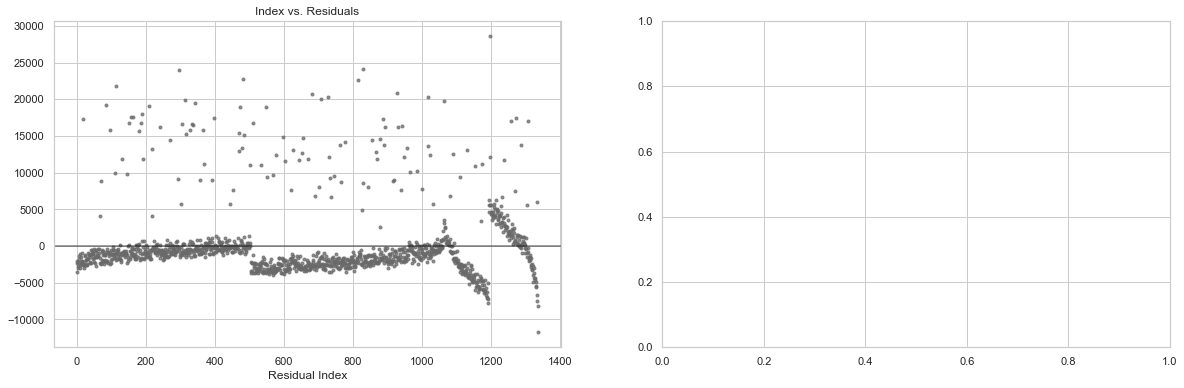

In [25]:
plot_residuals_sorted(data, m_3, ["smoker","bmi","obese"])

Wow, some more very interesting results. While we still have the same pattern in the smokers, we can now also see a pattern in the non-smokers: the residuals start negative and increase, with a drop when going from `obese=False` to `obese=True`. 

Overall, these patterns suggest that there is still yet more we can do to better fit a linear model. However, I think I will end my attempts here, carry out a bootstrap, and report the final results. 

In [26]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'residual', 'obese'],
      dtype='object')

In [27]:
m_final = models.bootstrap_linear_regression("charges ~ bmi + smoker + age + region + children + obese + smoker:bmi", data)
m_final["adj_r_squared"] = adjusted_r_squared(m_final)
models.describe_bootstrap_lr(m_final)

ValueError: 8 columns passed, passed data had 10 columns

Hmmm, I'm not quite sure how to get around this one.

I think I'll just report the final as produced from a standard linear regression

In [28]:
models.simple_describe_lr(m_3)